In [20]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # conv1, 加padding扩充成32*32
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # conv2
        self.conv2 = nn.Conv2d(6, 16, 5)
    
        # fc
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # conv --> relu --> maxpool
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        # num_flat_feaures = 16*16*5
        x = x.view(-1, self.num_flat_features(x))
        
        # fc1 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
        
        

train size torch.Size([60000, 28, 28])
train label size torch.Size([60000])


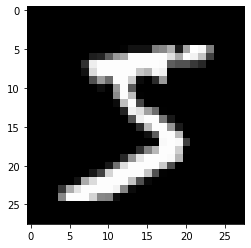

In [21]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

EPOCH = 10               # 训练epoch次数
BATCH_SIZE = 64          # 批训练的数量
LR = 0.001               # 学习率      

train_data = datasets.MNIST(root='./mnist/', train=True,transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./mnist/', train=False,transform=transforms.ToTensor(), download=True)


test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255
test_y = test_data.test_labels.numpy()[:2000]

import matplotlib.pyplot as plt
%matplotlib inline

print("train size", train_data.train_data.size())
print("train label size", train_data.train_labels.size())

plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.show()


In [27]:
# 使用dataloader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# model
model = LeNet5()
# loss functino
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# train
for epoch in range(EPOCH):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # gpu use
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        # loss
        loss = criterion(outputs, labels)
        # zero_grad
        optimizer.zero_grad()
        # backward
        loss.backward()
        # step 参数更新
        optimizer.step()
        
    # 为什么用item，因为loss只有一个数值
    print('epoch{} loss:{:.4f}%'.format(epoch+1, loss.item()))



epoch1 loss:0.0476
epoch2 loss:0.0197
epoch3 loss:0.0074
epoch4 loss:0.0149
epoch5 loss:0.0090
epoch6 loss:0.0928
epoch7 loss:0.0262
epoch8 loss:0.0013
epoch9 loss:0.0066
epoch10 loss:0.0015


In [28]:
# 保存模型
torch.save(model, 'mnist_lenet.pt')
model = torch.load('mnist_lenet.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    # forward
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total = total + labels.size(0)
    correct += (predicted==labels).sum().item()
    
# correct 
print('10000 test correct:{:.4f}%'.format(100*correct/total))

10000 test correct:98.8800%
